# BTC–ETH Portfolio Optimization (2018–2025)

This notebook builds on the BTC vs ETH performance analysis and explores
how different BTC/ETH allocations behave in terms of:

- Return
- Volatility
- Max drawdown
- Sharpe ratio (risk-adjusted return)

**Goal:** Identify how mixing BTC and ETH changes risk and reward compared
to holding either asset alone.


In [5]:
!pip install yfinance seaborn


In [8]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

BASE_DIR = "btc-eth-performance-analysis"
DATA_DIR = f"{BASE_DIR}/data"
CHARTS_DIR = f"{BASE_DIR}/charts"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(CHARTS_DIR, exist_ok=True)


## 1. Load BTC & ETH Data

We download daily historical prices for:

- `BTC-USD`
- `ETH-USD`

From 2018-01-01 to today using Yahoo Finance.


In [9]:
TICKERS = ["BTC-USD", "ETH-USD"]
START_DATE = "2018-01-01"
END_DATE = None  # up to latest available

raw = yf.download(
    TICKERS,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True,
    progress=False
)

close = raw["Close"].copy()
close.columns = ["BTC", "ETH"]

# Daily returns
returns = close.pct_change().dropna()

close.head(), returns.head()


(                   BTC      ETH
 Date                           
 2018-01-01 13,657.2002 772.6410
 2018-01-02 14,982.0996 884.4440
 2018-01-03 15,201.0000 962.7200
 2018-01-04 15,599.2002 980.9220
 2018-01-05 17,429.5000 997.7200,
               BTC    ETH
 Date                    
 2018-01-02 0.0970 0.1447
 2018-01-03 0.0146 0.0885
 2018-01-04 0.0262 0.0189
 2018-01-05 0.1173 0.0171
 2018-01-06 0.0056 0.0441)

## 2. Portfolio Metrics

We define helper functions to compute:

- Annualized return (CAGR)
- Annualized volatility
- Sharpe ratio (assuming risk-free = 0)
- Max drawdown (worst peak-to-trough decline)


In [10]:
TRADING_DAYS = 365
RISK_FREE_RATE = 0.00

def annualized_return(daily_returns: pd.Series) -> float:
    cumulative = (1 + daily_returns).prod() - 1
    years = (daily_returns.index[-1] - daily_returns.index[0]).days / 365.0
    return (1 + cumulative) ** (1 / years) - 1

def annualized_volatility(daily_returns: pd.Series) -> float:
    return daily_returns.std() * np.sqrt(TRADING_DAYS)

def sharpe_ratio(daily_returns: pd.Series, rf: float = 0.0) -> float:
    ar = annualized_return(daily_returns)
    vol = annualized_volatility(daily_returns)
    return (ar - rf) / vol if vol != 0 else np.nan

def compute_drawdown(daily_returns: pd.Series) -> pd.Series:
    wealth = (1 + daily_returns).cumprod()
    running_max = wealth.cummax()
    drawdown = (wealth - running_max) / running_max
    return drawdown


## 3. Construct BTC–ETH Portfolios

We create a range of BTC/ETH allocations.

Weights are BTC %, ETH % = (1 - BTC %):

- 0% BTC / 100% ETH
- 10% BTC / 90% ETH
- ...
- 90% BTC / 10% ETH
- 100% BTC / 0% ETH

For each allocation, we compute:

- Return
- Volatility
- Sharpe ratio
- Max drawdown


In [11]:
weights = np.linspace(0, 1, 11)  # 0.0, 0.1, 0.2, ... 1.0

portfolio_rows = []

for w_btc in weights:
    w_eth = 1 - w_btc

    # Portfolio daily returns = weighted sum
    port_returns = w_btc * returns["BTC"] + w_eth * returns["ETH"]

    # Metrics
    ar = annualized_return(port_returns)
    vol = annualized_volatility(port_returns)
    sr = sharpe_ratio(port_returns, RISK_FREE_RATE)
    dd = compute_drawdown(port_returns)
    max_dd = dd.min()

    portfolio_rows.append({
        "w_BTC": w_btc,
        "w_ETH": w_eth,
        "Annualized Return": ar,
        "Annualized Volatility": vol,
        "Sharpe Ratio": sr,
        "Max Drawdown": max_dd
    })

portfolios_df = pd.DataFrame(portfolio_rows)
portfolios_df


,w_BTC,w_ETH,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
0,0.0000,1.0000,0.1983,0.8514,0.2329,-0.9396
1,0.1000,0.9000,0.2182,0.8200,0.2661,-0.9303
2,0.2000,0.8000,0.2355,0.7905,0.2979,-0.9197
3,0.3000,0.7000,0.2500,0.7630,0.3277,-0.9078
4,0.4000,0.6000,0.2617,0.7379,0.3547,-0.8944
5,0.5000,0.5000,0.2705,0.7153,0.3782,-0.8794
6,0.6000,0.4000,0.2763,0.6955,0.3973,-0.8627
7,0.7000,0.3000,0.2791,0.6789,0.4111,-0.8506
8,0.8000,0.2000,0.2788,0.6655,0.4189,-0.8391
9,0.9000,0.1000,0.2753,0.6556,0.4200,-0.8273


## 4. Efficient Frontier (Risk vs Return)

We visualize each BTC/ETH allocation as a point with:

- X-axis: Annualized volatility (risk)
- Y-axis: Annualized return

This is a simple efficient frontier for BTC/ETH.


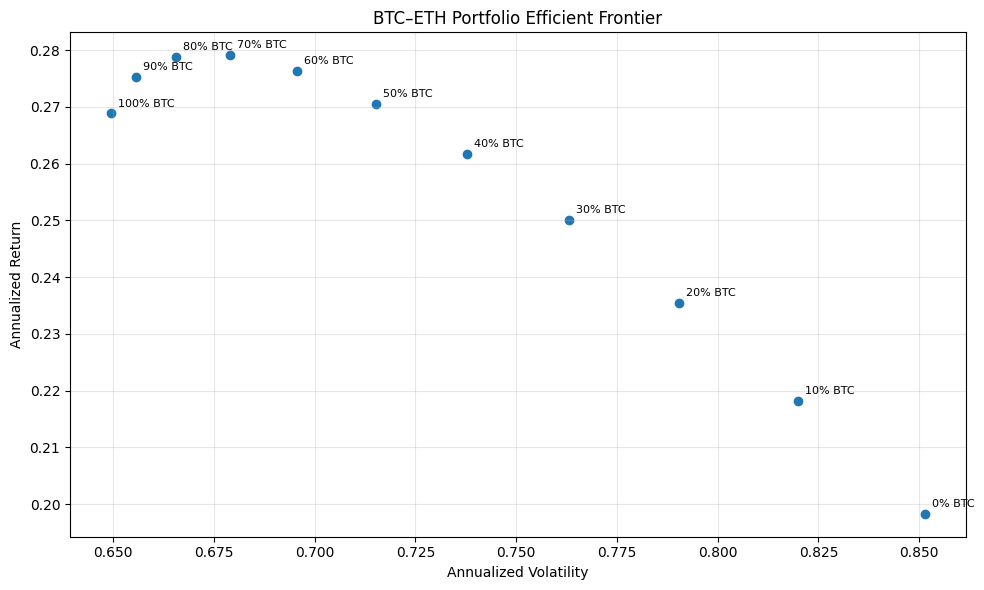

'btc-eth-performance-analysis/charts/btc_eth_efficient_frontier.png'

In [12]:
plt.figure(figsize=(10, 6))

plt.scatter(
    portfolios_df["Annualized Volatility"],
    portfolios_df["Annualized Return"],
)

# highlight a few key allocations
for _, row in portfolios_df.iterrows():
    label = f"{int(row['w_BTC']*100)}% BTC"
    plt.annotate(
        label,
        (row["Annualized Volatility"], row["Annualized Return"]),
        textcoords="offset points",
        xytext=(5, 5),
        fontsize=8
    )

plt.title("BTC–ETH Portfolio Efficient Frontier")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.grid(alpha=0.3)
plt.tight_layout()

frontier_path = f"{CHARTS_DIR}/btc_eth_efficient_frontier.png"
plt.savefig(frontier_path, dpi=300)
plt.show()

frontier_path


## 5. Compare Key Portfolios

We take a closer look at:

- 100% BTC
- 50% BTC / 50% ETH
- 100% ETH

and compare:

- Annualized return
- Volatility
- Max drawdown
- Sharpe ratio


In [13]:
key_weights = [0.0, 0.5, 1.0]  # 0% BTC, 50% BTC, 100% BTC

key_ports = portfolios_df[portfolios_df["w_BTC"].isin(key_weights)].copy()
key_ports


,w_BTC,w_ETH,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
0,0.0000,1.0000,0.1983,0.8514,0.2329,-0.9396
5,0.5000,0.5000,0.2705,0.7153,0.3782,-0.8794
10,1.0000,0.0000,0.2688,0.6494,0.4140,-0.8153


## 6. Export Portfolio Metrics

We save the portfolio metrics table as a CSV for reuse in:

- Dashboards
- Reports
- Websites
- Other notebooks


In [14]:
portfolio_metrics_path = f"{DATA_DIR}/portfolio_metrics_btc_eth.csv"
portfolios_df.to_csv(portfolio_metrics_path, index=False)
portfolio_metrics_path


'btc-eth-performance-analysis/data/portfolio_metrics_btc_eth.csv'

## 7. Interpretation & Takeaways

Key patterns to look for:

- Does mixing BTC and ETH **reduce volatility** compared to 100% ETH?
- Is there a middle allocation (e.g., 50/50 or 70/30) with:
  - Solid return
  - Lower drawdown
  - Better Sharpe ratio than pure BTC or pure ETH?

**Example framing (adjust based on your results):**

- 100% ETH may have the highest return but also the worst drawdown and volatility.
- 100% BTC may be more stable but with lower upside.
- A mixed BTC–ETH portfolio can offer:
  - Improved risk-adjusted return (higher Sharpe)
  - Less extreme drawdown than 100% ETH
  - Better growth than 100% BTC

This demonstrates how **portfolio construction can be more powerful than just choosing a single asset.**


## 8. Future Work

Ideas to extend this analysis:

- Add other assets (SOL, AVAX, stablecoins) to portfolios
- Include ETH staking yield for total return
- Add monthly or quarterly rebalancing rules
- Perform rolling window analysis (e.g., rolling Sharpe)
- Build a Streamlit app where users choose their own BTC/ETH weights

---

*Notebook by Insights Vault — crypto performance explained with data, not hype.*
